In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

## Analyze encoding-RBM

In [2]:
from rbms.utils import get_saved_updates
from rbms.io import load_model
from rbms.sampling.gibbs import sample_state
from adabmDCA.fasta import get_tokens, encode_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

device = torch.device("cuda")
dtype = torch.float32

In [3]:
dataset_name = "RR"
t1s = [0.4, 0.7]
num_train_seqs = 100

tokens = get_tokens("protein")
fname_model = f"../experiments/models/{dataset_name}/rbm/embeddingRBM.h5"

Import train and test data

In [4]:
def import_data(dataset_name, t1, num_train_seqs):
    fname_train = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_seqs}.csv"
    df_train = pd.read_csv(fname_train)
    X_train, y_train = df_train["sequence_align"].values, df_train["label"].values
    X_train = encode_sequence(X_train, tokens)
    X_train = torch.tensor(X_train).to(dtype=dtype, device=device)

    fname_test = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/test.csv"
    df_test = pd.read_csv(fname_test)
    X_test, y_test = df_test["sequence_align"].values, df_test["label"].values
    X_test = encode_sequence(X_test, tokens)
    X_test = torch.tensor(X_test).to(dtype=dtype, device=device)
    
    # Prepare input for the model
    X_train_input = {"visible": X_train}
    X_test_input = {"visible": X_test}

    return X_train_input, y_train, X_test_input, y_test

Test model at different save upadates

In [5]:
saved_updates = get_saved_updates(filename=fname_model)

f1s = {t1: [] for t1 in t1s}
for t1 in t1s:
    print(f"Processing t1={t1}")
    X_train_input, y_train, X_test_input, y_test = import_data(
        dataset_name=dataset_name, t1=t1, num_train_seqs=num_train_seqs
    )
    for su in saved_updates:
        print(f"Loading model at update {su}")
        params, *_ = load_model(
            filename=fname_model, index=su, device=device, dtype=dtype
        )
        H_train = params.sample_hiddens(X_train_input)["hidden_mag"].cpu().numpy()
        H_test = params.sample_hiddens(X_test_input)["hidden_mag"].cpu().numpy()
        
        scaler = StandardScaler()
        scaler.fit(H_train)
        H_train = scaler.transform(H_train)
        H_test = scaler.transform(H_test)
    
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(H_train, y_train)
        y_pred = logreg.predict(H_test)
        
        f1 = f1_score(y_test, y_pred, average="weighted")
        f1s[t1].append(f1)

Processing t1=0.4


Loading model at update 1
Loading model at update 2
Loading model at update 3
Loading model at update 5
Loading model at update 6
Loading model at update 7
Loading model at update 9
Loading model at update 12
Loading model at update 15
Loading model at update 19
Loading model at update 25
Loading model at update 31
Loading model at update 39
Loading model at update 50
Loading model at update 63
Loading model at update 79
Loading model at update 99
Loading model at update 125
Loading model at update 158
Loading model at update 199
Loading model at update 251
Loading model at update 316
Loading model at update 398
Loading model at update 501
Loading model at update 630
Loading model at update 794
Loading model at update 999
Loading model at update 1258
Loading model at update 1584
Loading model at update 1995
Loading model at update 2511
Loading model at update 3162
Loading model at update 3981
Loading model at update 5011
Loading model at update 6309
Loading model at update 7943
Loading

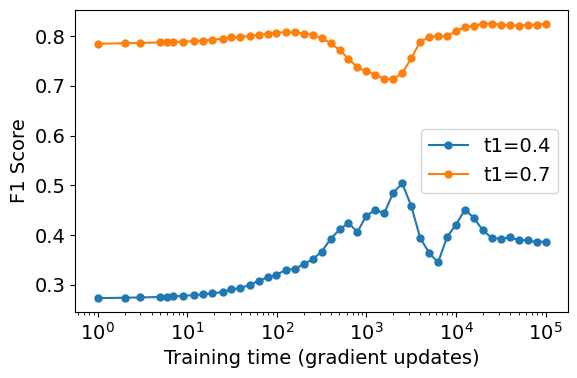

In [ ]:
# set global font size for plots
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(saved_updates, f1s[0.4], "-o", label="t1=0.4", ms=5)
ax.plot(saved_updates, f1s[0.7], "-o", label="t1=0.7", ms=5)
ax.set_xlabel("Training time (gradient updates)")
ax.set_ylabel("F1 Score")
ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.show()

## Class abundance for RR and CM

In [8]:
dataset_name = "RR"
num_train_seqs = 100
t1 = 0.4

fname_train = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_seqs}.csv"
df_train = pd.read_csv(fname_train)

fname_test = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/test.csv"
df_test = pd.read_csv(fname_test)

/tmp/ipykernel_400167/3712880751.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')
/tmp/ipykernel_400167/3712880751.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')


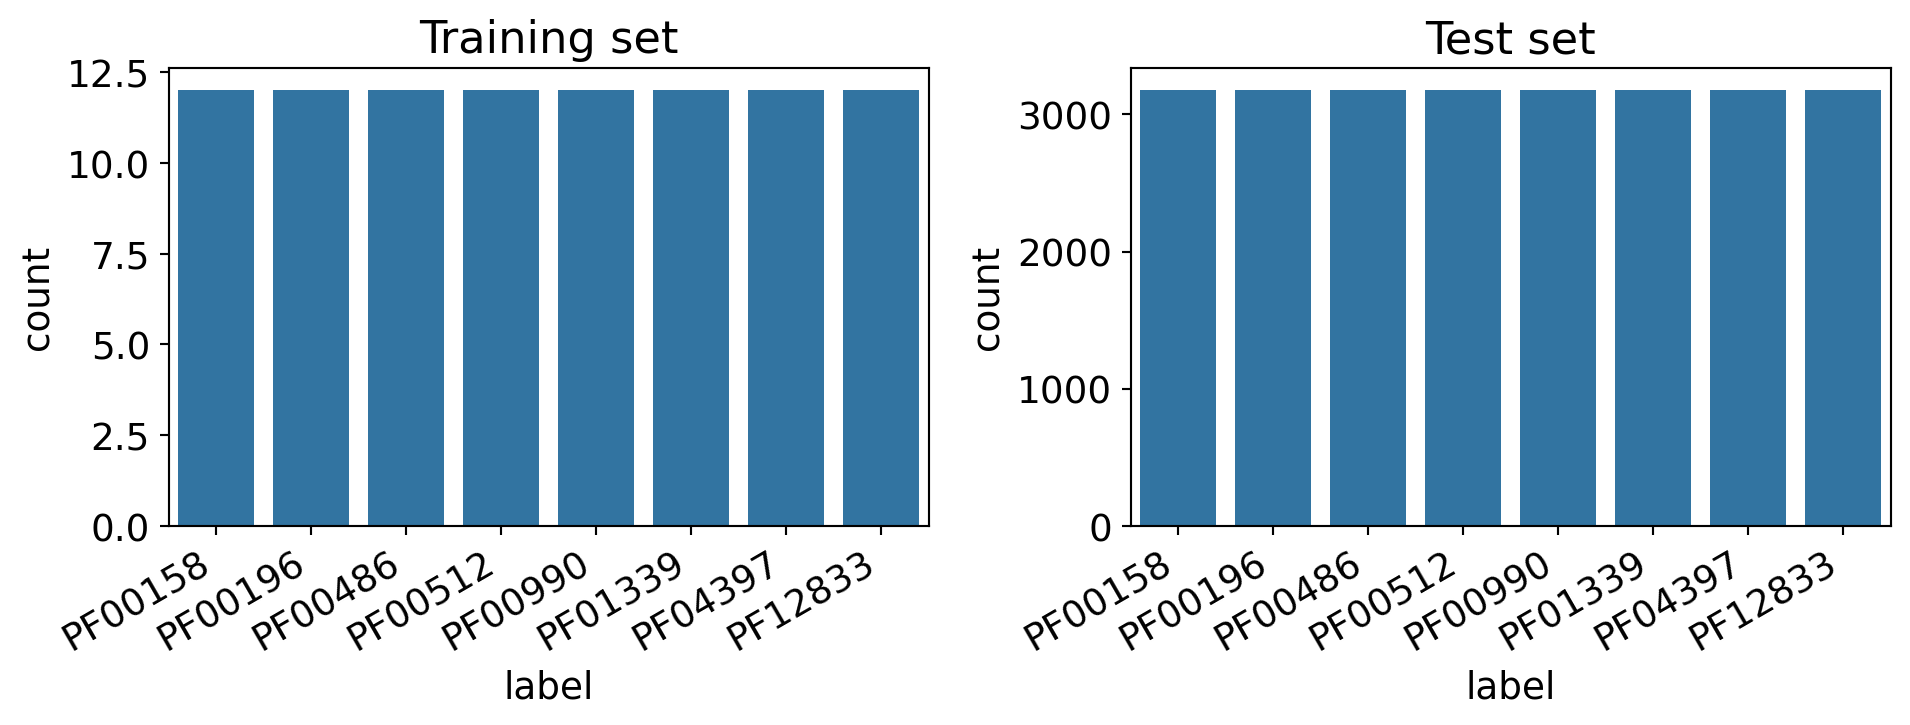

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=192)
sns.countplot(x="label", data=df_train, ax=axes[0])
axes[0].set_title("Training set")
sns.countplot(x="label", data=df_test, ax=axes[1])
axes[1].set_title("Test set")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')
# axes[0].set_yscale("log")
# axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [10]:
df_train["label"].value_counts()

label
PF00158    12
PF00196    12
PF00486    12
PF00512    12
PF00990    12
PF01339    12
PF04397    12
PF12833    12
Name: count, dtype: int64

## Investigate datasets

In [11]:
dataset_name = "CM"
t1 = 0.7
num_train_seqs = 529

In [12]:
fname_train = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_seqs}.csv"
df_train = pd.read_csv(fname_train)
fname_test = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/test.csv"
df_test = pd.read_csv(fname_test)
fname_all = f"../experiments/datasets/CM/cm_russ_natural.csv"
df_all = pd.read_csv(fname_all)

In [13]:
len(df_train), len(df_test), len(df_all)

(529, 363, 1130)

In [14]:
len(df_train["label"].unique())

2

## PCAs of the datasets

In [15]:
from adabmDCA.fasta import get_tokens, encode_sequence
from sklearn.decomposition import PCA

In [16]:
fnames_data = {
    "RR": "../experiments/datasets/RR/RR.csv",
    "SH3": "../experiments/datasets/SH3/SH3.csv",
    "Globin": "../experiments/datasets/Globin/Globin_morkos.csv",
    "CM": "../experiments/datasets/CM/cm_russ_natural.csv"
}

In [17]:
tokens = get_tokens("protein")
max_size = 20000

def get_data_projections(path_data, max_size=None):
    df = pd.read_csv(path_data)
    # only consider sequences with labels
    df = df[df["label"].notna()]
    sequence_col_name = "sequence_align" if "sequence_align" in df.columns else "sequence"
    X = df[sequence_col_name].values
    y = df["label"].values
    if max_size is not None and len(X) > max_size:
        perm = np.random.permutation(len(X))[:max_size]
        X = X[perm]
        y = y[perm]
    X = encode_sequence(X, tokens)
    X = np.eye(len(tokens))[X].reshape(len(X), -1)
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    return X, np.array(y)

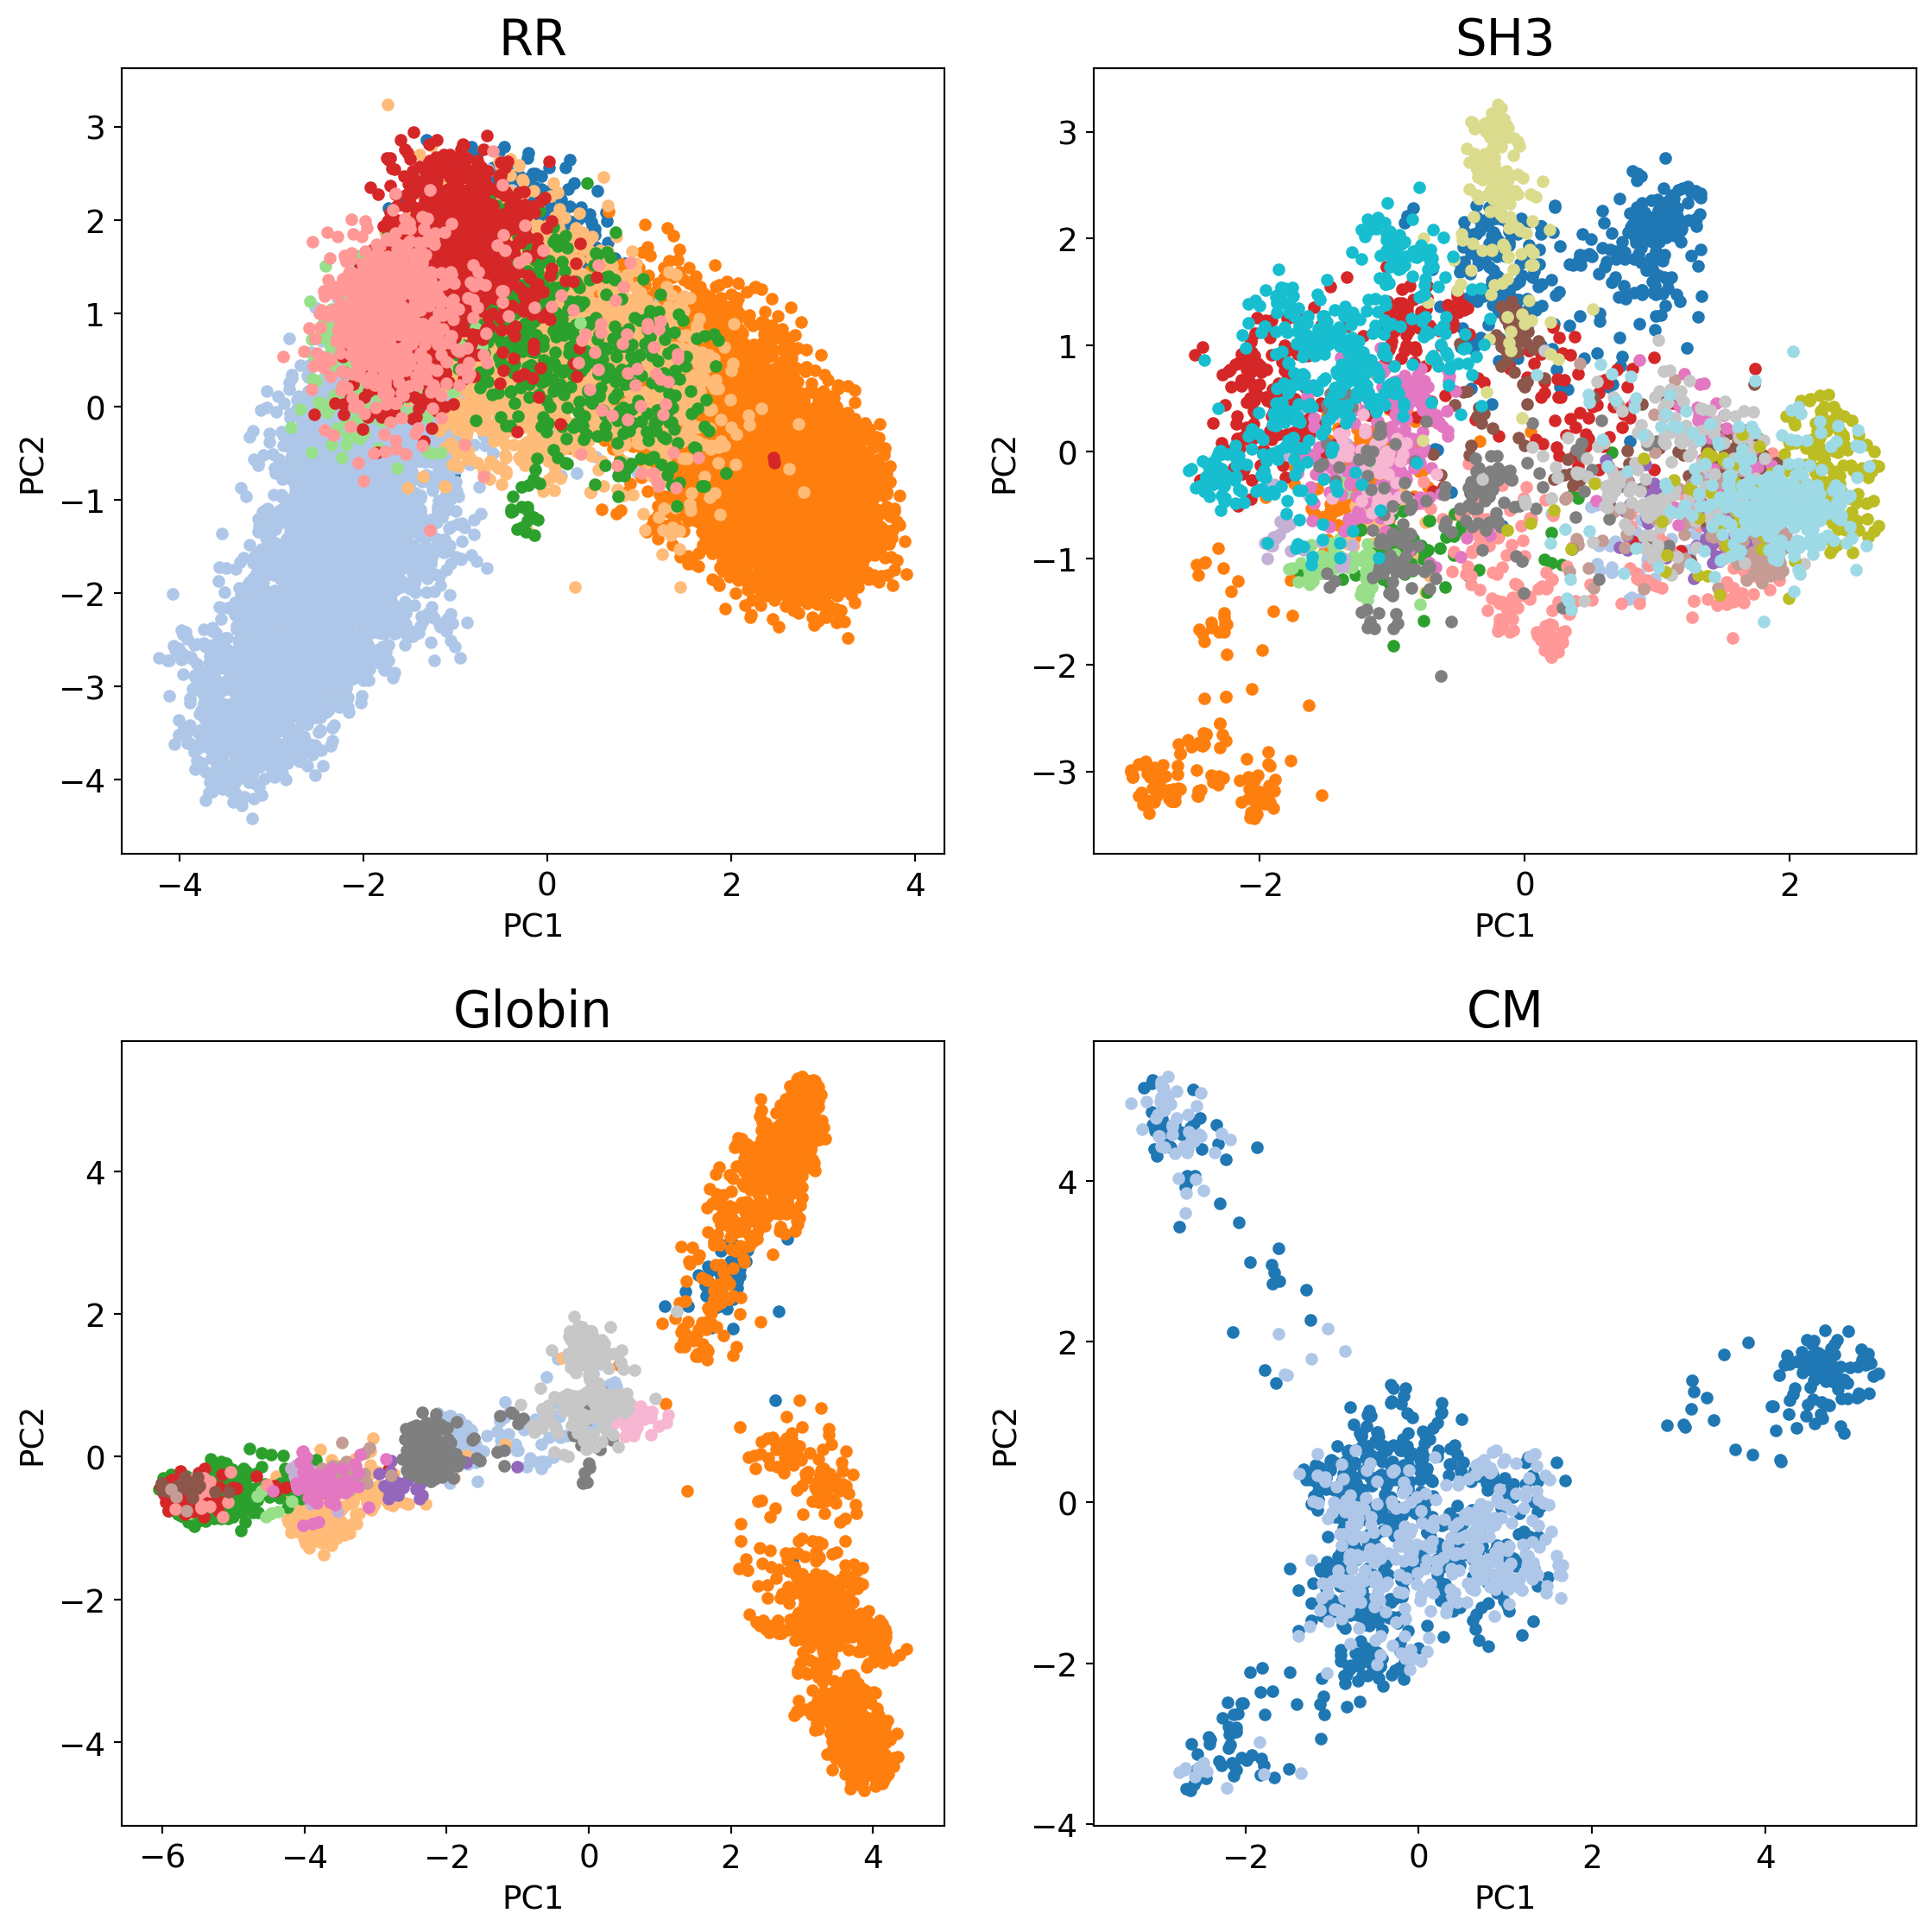

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=192)
plt.rcParams.update({'text.usetex': True, 'font.size': 18})
# set tick size
plt.rcParams.update({'xtick.labelsize': 18, 'ytick.labelsize': 18})

colormap = plt.get_cmap("tab20")
for i, (dataset_name, fname_data) in enumerate(fnames_data.items()):
    X, y = get_data_projections(fname_data, max_size=max_size)
    
    ax_i = ax[i // 2, i % 2]
    unique_labels = np.unique(y)
    ax_i.set_title(f"{dataset_name}")
    ax_i.set_xlabel("PC1")
    ax_i.set_ylabel("PC2")
    for j, label in enumerate(unique_labels):
        X_label = X[y == label]
        ax_i.scatter(X_label[:, 0], X_label[:, 1], label=f"Label {label}", alpha=1.0, s=20, color=colormap(j))
        
plt.tight_layout()